# Bookkeeping
This notebook is used to check the status of processing tasks for the project and make lists of to-do items.


## Data structure
Cases are 


Each case needs to have the following for both Aqua and Terra
- modis truecolor
- modis falsecolor
- modis cloudfraction
- modis landmask

They're stored in the `data/modis` folder. There should be a file for each case and for each satellite.

## TBD
- Add step to check whether the image dimensions are correct.

In [1]:
import pandas as pd
import numpy as np
import os
import pyproj 

## Verify MODIS data availability

In [9]:
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)
# cases = pd.read_csv('../data/metadata/validation_dataset_case_list.csv')
case_df = pd.read_csv('../data/metadata/merged_validation_table.csv')
case_df['case_number'] = [str(x).zfill(3) for x in case_df['case_number']]

# satellite = ['aqua']*len(case_numbers) + ['terra']*len(case_numbers)
# case_df = pd.DataFrame({'case_number': case_numbers*2,
                        # 'satellite': satellite})

modis_loc = '../data/modis/'
truecolor_files = [f for f in os.listdir(modis_loc + 'truecolor') if 'tiff' in f]
falsecolor_files = [f for f in os.listdir(modis_loc + 'falsecolor') if 'tiff' in f]
cloudfraction_files = [f for f in os.listdir(modis_loc + 'cloudfraction') if 'tiff' in f]
landmask_files = [f for f in os.listdir(modis_loc + 'landmask') if 'tiff' in f]



# Organize the data from the filenames into dataframes
fc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in falsecolor_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
tc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in truecolor_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
cl_df = pd.DataFrame([x.replace('.', '-').split('-') for x in cloudfraction_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
lm_df = pd.DataFrame([x.replace('.', '-').split('-') for x in landmask_files if '.tiff' in x],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])

# # Landmask doesn't vary with date or satellite so those values not included in filename
# lm_df = pd.DataFrame([x.replace('.', '-').split('-') for x in landmask_files],
#                      columns=['case_number', 'region', 'dx', 'imtype', 'ftype'])

# Use series of merges to check the imagery for each satellite
ref_df = case_df.merge(tc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df = ref_df.loc[:, ['case_number', 'satellite', 'imtype']].merge(fc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
print(ref_df.shape)

ref_df['truecolor'] = ref_df['imtype_x'].notnull()
ref_df['falsecolor'] = ref_df['imtype_y'].notnull()
ref_df.drop(['imtype_x', 'imtype_y'], axis=1, inplace=True)

ref_df = ref_df.merge(cl_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['cloudfraction'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

ref_df = ref_df.merge(lm_df.loc[:, ['case_number', 'satellite', 'imtype']],
                      left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['landmask'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

(378, 4)


In [3]:
ref_df.columns

Index(['case_number', 'satellite', 'truecolor', 'falsecolor', 'cloudfraction',
       'landmask'],
      dtype='object')

In [6]:
for x in truecolor_files:
    if len(x.replace('.', '-').split('-')) != 8:
        print(x)

In [7]:
print('MODIS data availability\n-----------------------')
expected = len(case_df)
for imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask']:
    n = ref_df[imtype].notnull().sum()
    if n == expected:
        print(imtype, n, '/', expected)
    else:
        print(imtype, n, '/', expected, 'missing {x} files'.format(x=expected - n))
        print('    ', 'data missing from case(s)', ', '.join(np.unique(ref_df.loc[~ref_df[imtype],'case_number'].values)))

MODIS data availability
-----------------------
truecolor 378 / 378
falsecolor 378 / 378
cloudfraction 378 / 378
landmask 378 / 378


# MASIE data availability
- full image downloaded?
- cropped image created?

# Initializing the validation data tables
Image metadata from prior work is in the init_validation_tables folder. We'll merge this table with the new samples, and create an updated validation table to put the image annotations in.


In [8]:
print('QA Review needed for', data.qa_reviewer.isnull().sum(), 'image(s)')
data.loc[data.qa_reviewer.isnull(), ['case_number', 'region', 'satellite', 'qa_analyst', 'qa_reviewer']]

NameError: name 'data' is not defined

Next, we need to see if the information in the "floe labeling analyst" (`fl_analyst`) category is correct.

# Checking the status of the validation imagery
Validation imagery comes in multiple categories: manually labeled and algorithmic labels. In the former category, we are checking the floe labeling column against the files found in the `labeled_floes_png`, `labeled_landfast_ice`, and `landmask_png` folders. 

First, we look to see if any images are listed in the data table that are missing from the folder.

If nothing prints, then all the images listed in the table are present.

In [14]:
imtype = 'labeled_floes' # landmask, # labeled_floes
dataloc = '../data/validation_images/'
tbd = []
for row, case in case_df.iterrows():
    cn = str(case.case_number).zfill(3)
    region = case.region
    start = case.start_date
    satellite = case.satellite
    if case.notnull().fl_analyst:
        missing = []
        for imtype in ['labeled_floes', 'binary_floes', 'binary_landmask', 'binary_landfast']:
            ftype = 'png'
            imtype2 = imtype
            if imtype == 'labeled_floes':
                ftype = 'tiff'
            elif imtype == 'binary_landmask':
                imtype2 = 'landmask'
            image_path = dataloc + imtype + '/' + '-'.join([cn, region, start.replace('-', ''), satellite, imtype2]) + '.' + ftype               
            if not os.path.isfile(image_path):
                missing.append(imtype)    
        if len(missing) > 0:
            print(cn, satellite, region, ' '.join(missing), case.fl_analyst)
    elif case.visible_floes == 'yes':
        tbd.append('-'.join([cn, satellite, region]))

In [17]:
len(tbd)

108

Next, check if any files in the folder aren't in the table.

Labeled floes:

In [22]:
files = [f for f in os.listdir(dataloc + 'labeled_floes') if 'tiff' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

111-greenland_sea-20120623-aqua-labeled_floes.tiff
111-greenland_sea-20120623-terra-labeled_floes.tiff
129-hudson_bay-20100324-aqua-labeled_floes.tiff
129-hudson_bay-20100324-terra-labeled_floes.tiff


Labeled landfast:

In [20]:
files = [f for f in os.listdir(dataloc + 'binary_landfast') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

067-bering_chukchi_seas-20080623-aqua-binary_landfast.png
067-bering_chukchi_seas-20080623-terra-binary_landfast.png
088-east_siberian_sea-20140808-aqua-binary_landfast.png
088-east_siberian_sea-20140808-terra-binary_landfast.png
111-greenland_sea-20120623-aqua-binary_landfast.png
111-greenland_sea-20120623-terra-binary_landfast.png
129-hudson_bay-20100324-aqua-binary_landfast.png
129-hudson_bay-20100324-terra-binary_landfast.png


Landmask:

In [21]:
files = [f for f in os.listdir(dataloc + 'binary_landmask') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = case_df.loc[((case_df.case_number == cn) & (case_df.region == region)) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

067-bering_chukchi_seas-20080623-aqua-landmask.png
067-bering_chukchi_seas-20080623-terra-landmask.png
088-east_siberian_sea-20140808-aqua-landmask.png
088-east_siberian_sea-20140808-terra-landmask.png
111-greenland_sea-20120623-aqua-landmask.png
111-greenland_sea-20120623-terra-landmask.png
129-hudson_bay-20100324-aqua-landmask.png
129-hudson_bay-20100324-terra-landmask.png


Photoshop file:

In [23]:
files = [f for f in os.listdir(dataloc + 'labeling_psd_files/labeling_done') if 'psd' in f]
files.sort()
for file in files:
    cn = file.split('-')[0]
    if 'aqua' in file:
        satellite == 'aqua'
    else:
        satellite == 'terra'
    
    row = case_df.loc[(case_df.case_number == cn) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.notnull()['fl_analyst'].values[0]:
            if row.isnull()['psd_file'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

# TBD

Number of floes needing review, metadata needed, and metadata review needed

In [24]:
print('Metadata needed:', len(case_df.loc[case_df.qa_analyst.isnull()]))
print('Metadata review needed:', len(case_df.loc[case_df.qa_analyst.notnull() & case_df.qa_reviewer.isnull()]))

print('Total images w/ floes:', len(case_df.loc[(case_df.visible_floes == 'yes'),:]))
print('Total labeled images:', len(case_df.loc[(case_df.visible_floes == 'yes') & case_df.fl_analyst.notnull(),:]))
print('Images remaining:', len(case_df.loc[((case_df.visible_floes == 'yes')) & (case_df.fl_analyst.isnull()),:]))
print('Floe labeling review needed:', len(case_df.loc[case_df.fl_analyst.notnull() & case_df.fl_reviewer.isnull()]))

Metadata needed: 0
Metadata review needed: 133
Total images w/ floes: 231
Total labeled images: 123
Images remaining: 108
Floe labeling review needed: 94


Remaining images to process by region:

In [25]:
case_df.loc[(((case_df.visible_floes == 'yes')) & (case_df.fl_analyst.isnull())),
['case_number', 'region']].groupby('region').count()

,case_number
region,
baffin_bay,10
barents_kara_seas,10
beaufort_sea,19
bering_chukchi_seas,19
east_siberian_sea,18
greenland_sea,13
hudson_bay,18
sea_of_okhostk,1


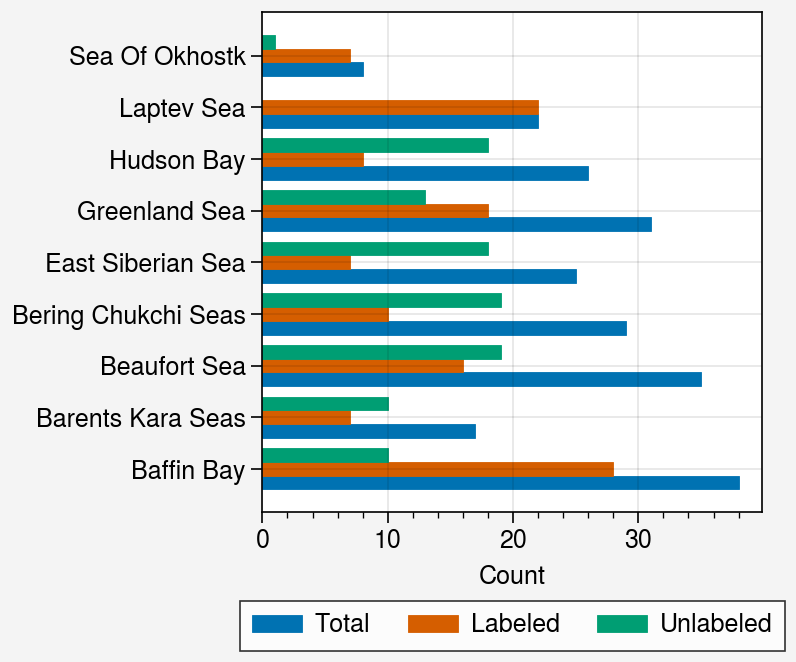

In [26]:
import proplot as pplt
data = case_df.copy()
total_to_label = data.loc[data.visible_floes == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
fig, ax = pplt.subplots()
ax.barh(df)
ax.format(xlabel='Count')
ax.legend(loc='b')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


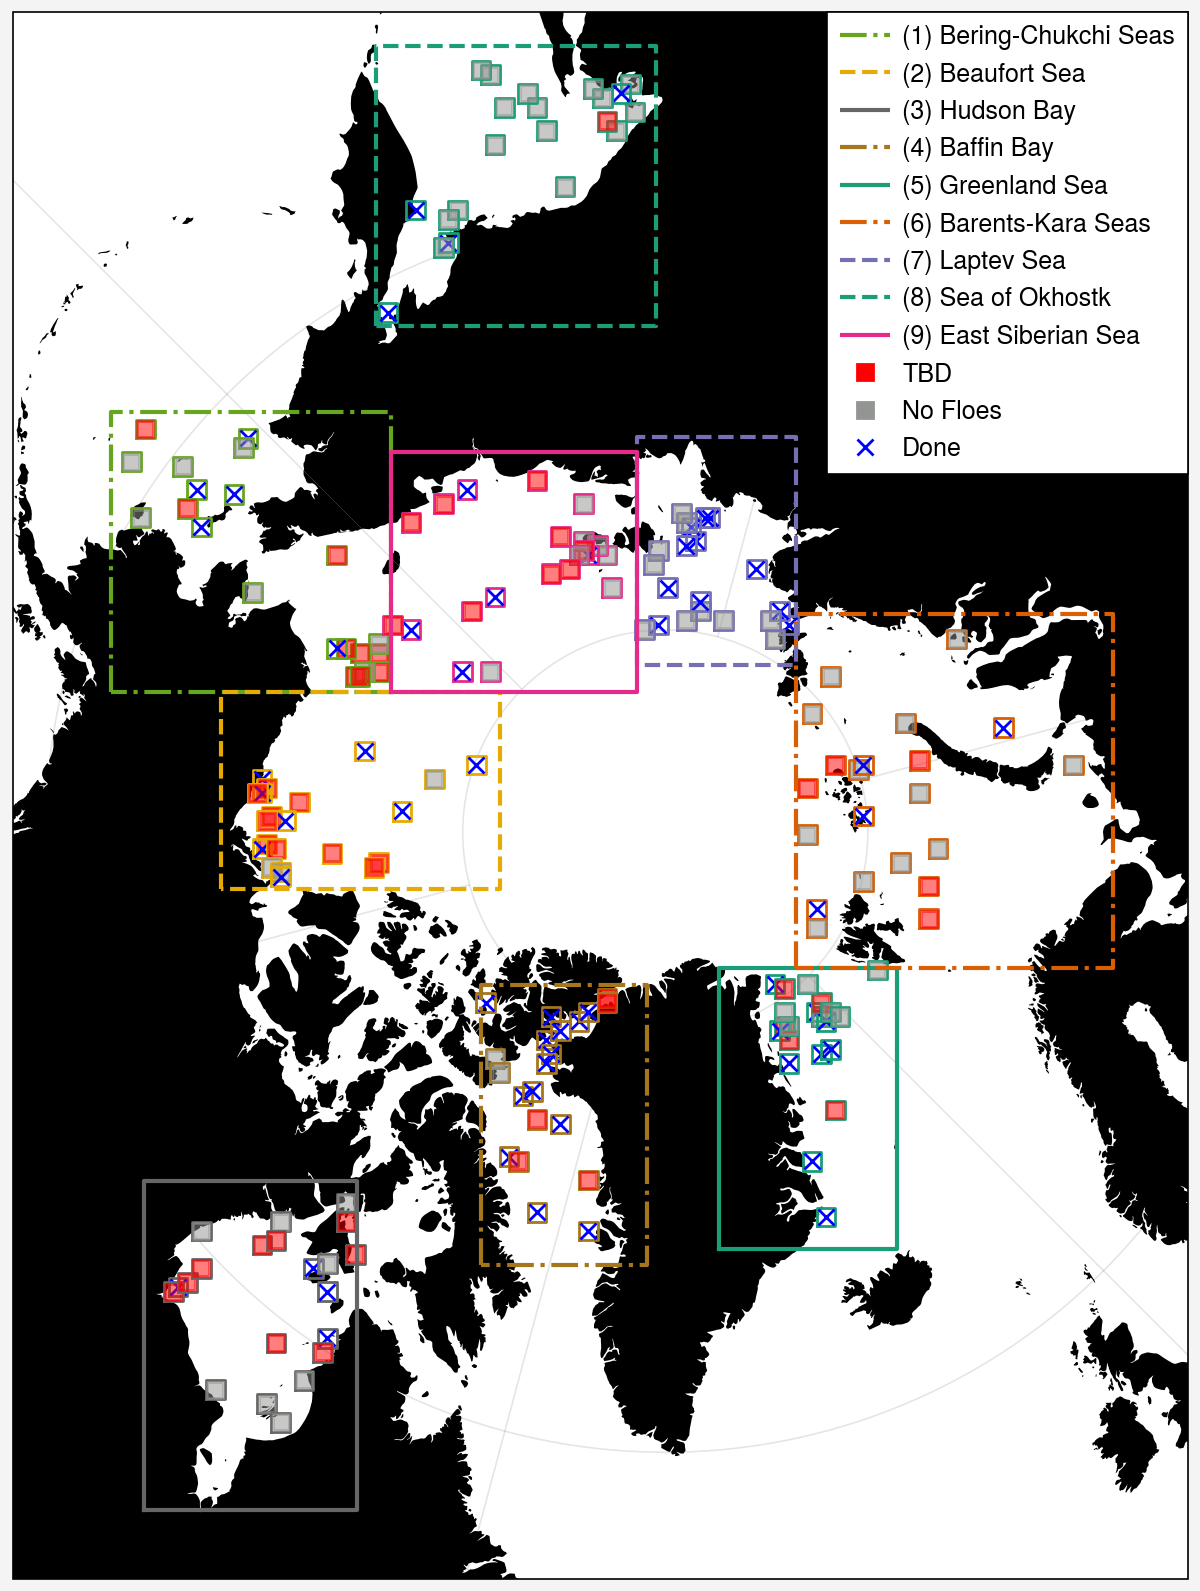

In [27]:
import proplot as pplt
import cartopy.crs as ccrs

df = pd.read_csv('../data/metadata/merged_validation_table.csv')
df = df.loc[df.satellite=='aqua']
df.index = [str(x).zfill(3) for x in df.case_number]

regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for idx, row in regions.iterrows():
    if row.print_title == 'Barents Kara Seas':
        regions.loc[idx, 'print_title'] = 'Barents-Kara Seas'
    if row.print_title == 'Bering Chukchi Seas':
        regions.loc[idx, 'print_title'] = 'Bering-Chukchi Seas'

pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
ax.format(land=True, landzorder=0)

validated_cases = df.loc[df.fl_analyst.notnull()]
needs_validation = df.loc[df.fl_analyst.isnull() & (df.visible_floes == 'yes')]

no_floes_cases = df.loc[df.visible_floes == 'no']

for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=ccrs.CRS('epsg:3413'),
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)
for idx, case in df.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region

    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color=colors[region], lw=1)
    if str(case.case_number).zfill(3) in validated_cases.index:
        ax.plot(x0, y0, m='x', color='b', transform=crs, label='')
    elif str(case.case_number).zfill(3) in no_floes_cases.index:
        ax.plot(x0, y0, m='s', color='gray', transform=crs, alpha=0.5, label='')
    elif str(case.case_number).zfill(3) in needs_validation.index:
        ax.plot(x0, y0, m='s', color='r', transform=crs, alpha=0.5, label='')        

ax.plot([],[],m='s', color='r', label='TBD', lw=0)
ax.plot([],[],m='s', color='gray', label='No Floes', lw=0)
ax.plot([],[],m='x', color='b', label='Done', lw=0)
ax.legend(ncols=1, alpha=1)

fig.save('../figures/progress_sampling_map.png', dpi=300)

# Summarizing the validation images
The floe size distribution and the total number of floes.

In [34]:
import pandas as pd
import rasterio as rio
from rasterio.plot import reshape_as_image
import skimage

# Load case data
df = pd.read_csv('../data/metadata/merged_validation_table.csv', parse_dates=['start_date'], index_col=0)

df['case_number'] = [str(cn).zfill(3) for cn in df.index]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.tiff'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
lb_dataloc = '../data/validation_images/labeled_floes/'
lb_images = {}

missing = []
for row, data in df.iterrows():
    if data.notnull().fl_analyst:
        with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
            lb_images[row] = im.read()[0, :,:]
            if lb_images[row].shape[0] != 400:
                print(row, lb_images[row].shape[0])

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


036_aqua 391
036_terra 391
075_aqua 391
075_terra 391


In [47]:
data = []
for row in lb_images:
    skimage.measure.regionprops_table(skimage.measure.label(lb_images[row]), properties=['area', 'label'])
    df = pd.DataFrame(skimage.measure.regionprops_table(
     skimage.measure.label(lb_images[row]),
     properties=['area', 'label']))
    df['case'] = row
    data.append(df)
data = pd.concat(data)

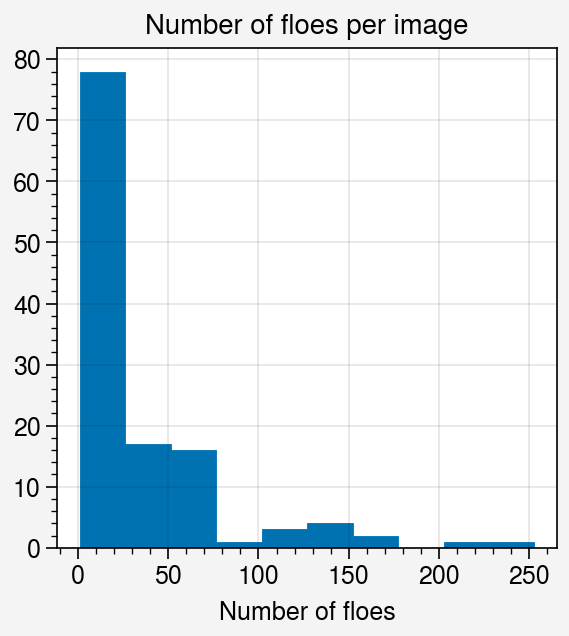

In [54]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.hist(data.groupby('case').count()['area'])
ax.format(xlabel='Number of floes', title='Number of floes per image')

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


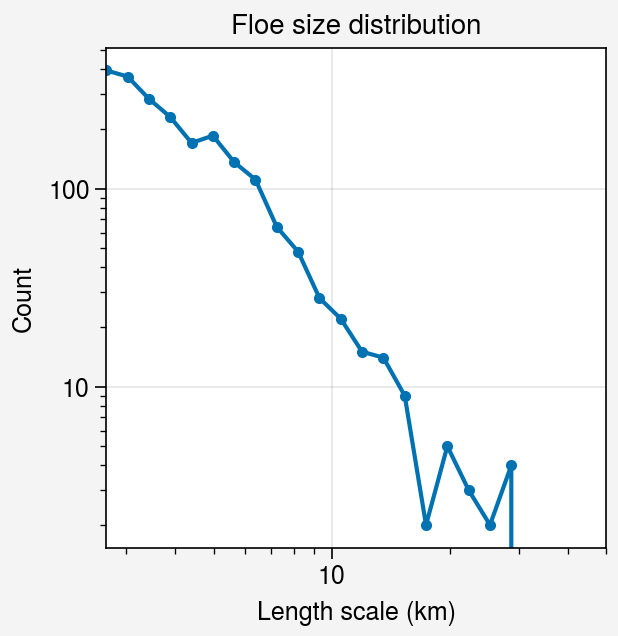

In [90]:
import numpy as np
fig, ax = pplt.subplots()

bins = np.logspace(1, np.log(np.sqrt(100)), 25)*0.25
x, xb = np.histogram(np.sqrt(data['area'])*0.25, bins)

ax.plot(0.5*(bins[:-1] + bins[1:]), x, marker='.')
ax.format(yscale='log', xscale='log', ylabel='Count',
          xlim=(0, 50), xlabel='Length scale (km)', title='Floe size distribution')

In [96]:
print('Total number of floes in ground truth data:', data.shape[0])
print('Median number of floes per image: ', data.groupby('case').count().median()['area'])

Total number of floes in ground truth data: 4173
Median number of floes per image:  15.0
